In [13]:
# importing required libraries
library(keras)
library(wvtool)
library(grid)
library(abind)

In [14]:
# loading the training and testing datasets
data <- dataset_cifar10()
x_train = data$train$x
x_test = data$test$x

In [15]:
# storing the relevant dimension data into respective variables.
num_images = dim(x_train)[1]
num_images_test = dim(x_test)[1]
img_width = dim(x_train)[2]
img_height = dim(x_train)[3]

In [16]:
# converting all the images in train and test data into grayscale images

# grayscale train set
x_train_gray <- apply(x_train[1:num_images,,,], c(1), FUN = function(x){
    rgb2gray(x, coefs=c(0.299, 0.587, 0.114))
})
x_train_gray <- t(x_train_gray)
x_train_gray = array(x_train_gray,dim = c(num_images,img_width,img_height))

# grayscale test set
x_test_gray <- apply(x_test[1:num_images_test,,,], c(1), FUN = function(x){
    rgb2gray(x, coefs=c(0.299, 0.587, 0.114))
})
x_test_gray <- t(x_test_gray)
x_test_gray = array(x_test_gray,dim = c(num_images_test,img_width,img_height))

In [17]:
# normalizing train and test coloured images
x_train = x_train / 255
x_test = x_test / 255

# normalizing train and test grayscale images
x_train_gray = x_train_gray / 255
x_test_gray = x_test_gray / 255

In [18]:
# reshaping each grayscale image into the shape of image height,image width and number of channels
x_train_gray <- array_reshape(x_train_gray,dim = c(num_images,img_height,img_width,1))
x_test_gray <- array_reshape(x_test_gray,dim = c(num_images_test,img_height,img_width,1))

In [19]:
# defining network parameters
input_shape = c(img_height, img_width, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

In [20]:
# creating an input layer of the autoencoder
inputs = layer_input(shape = input_shape,name = "encoder_input")

In [21]:
# configuring the layers of the encoder part of the network.
x = inputs

x <- x %>% layer_conv_2d(filters = 64,kernel_size = kernel_size,strides = 2,
                    activation = "relu",padding = "same") %>%
    layer_conv_2d(filters = 128,kernel_size = kernel_size,strides = 2,
                    activation = "relu",padding = "same") %>%
    layer_conv_2d(filters = 256,kernel_size = kernel_size,strides = 2,
                    activation = "relu",padding = "same")

In [22]:
# extracting the shape of the output tensor from the encoder network created above
shape = k_int_shape(x)

In [23]:
shape

[[1]]
NULL

[[2]]
[1] 4

[[3]]
[1] 4

[[4]]
[1] 256

In [24]:
# generating a latent vector
x <- x %>% layer_flatten()
latent <- x %>% layer_dense(units = latent_dim,name = "latent")
encoder = keras_model(inputs, latent)

In [25]:
# summary of the encoder model
summary(encoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
encoder_input (InputLayer)          (None, 32, 32, 1)               0           
________________________________________________________________________________
conv2d (Conv2D)                     (None, 16, 16, 64)              640         
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 8, 8, 128)               73856       
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 4, 4, 256)               295168      
________________________________________________________________________________
flatten (Flatten)                   (None, 4096)                    0           
________________________________________________________________________________
latent (Dense)              

In [26]:
# building the decoder model

# decoder input layer
latent_inputs = layer_input(shape = c(latent_dim), name='decoder_input')

x = latent_inputs %>% layer_dense(shape[[2]] * shape[[3]] * shape[[4]])
x = x %>% layer_reshape(c(shape[[2]], shape[[3]], shape[[4]]))

x <- x %>% layer_conv_2d_transpose(filters = 256,kernel_size = kernel_size,strides = 2,
                    activation = "relu",padding = "same")  %>%
    layer_conv_2d_transpose(filters = 128,kernel_size = kernel_size,strides = 2,
                    activation = "relu",padding = "same") %>%
    layer_conv_2d_transpose(filters = 64,kernel_size = kernel_size,strides = 2,
                activation = "relu",padding = "same")

outputs = x %>% layer_conv_2d_transpose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')

decoder = keras_model(latent_inputs, outputs)

In [27]:
# summary of the decoder model
summary(decoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
decoder_input (InputLayer)          (None, 256)                     0           
________________________________________________________________________________
dense (Dense)                       (None, 4096)                    1052672     
________________________________________________________________________________
reshape (Reshape)                   (None, 4, 4, 256)               0           
________________________________________________________________________________
conv2d_transpose (Conv2DTranspose)  (None, 8, 8, 256)               590080      
________________________________________________________________________________
conv2d_transpose_1 (Conv2DTranspose (None, 16, 16, 128)             295040      
________________________________________________________________________________
conv2d_transpose_2 (Conv2DTr

In [28]:
# autoencoder = encoder + decoder
autoencoder = keras_model(inputs, decoder(encoder(inputs)))

In [29]:
# summary of the autoencoder model
summary(autoencoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
encoder_input (InputLayer)          (None, 32, 32, 1)               0           
________________________________________________________________________________
model (Model)                       (None, 256)                     1418496     
________________________________________________________________________________
model_1 (Model)                     (None, 32, 32, 3)               2013315     
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
________________________________________________________________________________


In [30]:
# compiling the autoencoder
autoencoder %>% compile(loss='mse', optimizer='adam')

# training the autoencoder
autoencoder %>% fit(x_train_gray,
                    x_train,
                    validation_data= list(x_test_gray, x_test),
                    epochs=20,
                    batch_size=batch_size)

In [34]:
# using the trained model to generate predictions for test data
predicted <- autoencoder %>% predict(x_test_gray)

In [35]:
options(repr.plot.width=4, repr.plot.height=1)

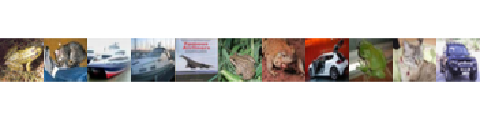

In [36]:
# original test images
grid = array_reshape(x_test[20,,,],dim = c(32,32,3))
for(i in seq(1,10)){
    grid = abind(grid,array_reshape(x_test[i,,,],dim = c(32,32,3)),along = 2)
}

grid.raster(grid,interpolate=FALSE)

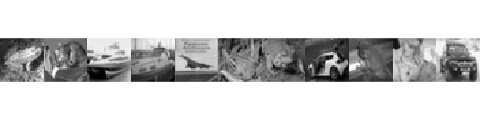

In [37]:
# greyscale test images
grid1 = array_reshape(x_test_gray[20,,,],dim = c(32,32))

for(i in seq(1,10)){
    grid1 = abind(grid1,array_reshape(x_test_gray[i,,,],dim = c(32,32)),along = 2)
}

grid.raster(grid1, interpolate=FALSE)

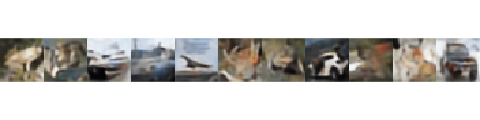

In [38]:
# predicted images -> black and white to coloured
grid2 = predicted[20,,,]
for(i in seq(1,10)){
    grid2 = abind(grid2,predicted[i,,,],along = 2)
}

grid.raster(grid2, interpolate=FALSE)